李佩瑶 22300180089 

实验记录在我的[github](https://github.com/5697526/CIFAR-10-Image-Classification.git)

## 一、实验目的

使用 numpy 手工搭建三层神经网络分类器，在数据集 CIFAR-10 上进行训练以实现图像分类。至少包含模型、训练、测试和参数查找四个部分。其中模型部分应允许自定义隐藏层大小、激活函数类型，支持通过反向传播计算给定损失的梯度；训练部分应实现 SGD 优化器、学习率下降、交叉熵损失和 L2 正则化，并能根据验证集指标自动保存最优的模型权重；参数查找环节要求调节学习率、隐藏层大小、正则化强度等超参数，观察并记录模型在不同超参数下的性能；测试部分需支持导入训练好的模型，输出在测试集上的分类准确率（Accuracy）。

## 二、数据集介绍

### 1. 数据集来源  


本次实验使用的是 CIFAR - 10 数据集，该数据集可从 [CIFAR - 10 ](https://www.cs.toronto.edu/~kriz/cifar.html)下载。


### 2. 数据集内容

CIFAR - 10 数据集总共包含 60,000 张 32×32 像素的彩色图像，涵盖有10个不同的类别：飞机（Airplane），汽车（Automobile），鸟（Bird），猫（Cat），鹿（Deer），狗（Dog），青蛙（Frog），马（Horse），船（Ship）和卡车（Truck）。数据集被划分为训练集和测试集两部分，其中训练集包含 50,000 张图像，每个类别有 5,000 张，测试集包含 10,000 张图像，每个类别有 1,000 张。图像采用 RGB 三通道模式，每个通道是一个 32×32 的矩阵，矩阵中的每个元素表示该通道在对应像素位置的颜色强度，取值范围为 0 - 255。



### 3. 数据格式与存储

CIFAR - 10 数据集以二进制文件的形式存储，分为多个批次。训练集被分成 5 个数据批次（data_batch_1 - data_batch_5），每个批次包含 10,000 张图像。测试集则存储在一个单独的文件（test_batch）中。每个数据批次文件包含图像数据和对应的标签，图像数据以一维数组的形式存储。

## 三、实验过程

### 1. 实验准备

确保已经安装了 Python 环境，并且安装了项目所需的依赖库。导入所需的库。

将 CIFAR - 10 数据集下载并解压到 ./data 目录下。

### 2. 数据处理

data_loader.py：预处理数据，对下载好的 CIFAR - 10 数据集进行数据加载、归一化和划分验证集。

#### (1) 数据加载：   


load_data函数用于加载 CIFAR-10 数据集。通过循环遍历data_batch_1到data_batch_5文件，使用pickle库读取训练数据，再读取test_batch文件中的测试数据。将每个文件中的'data'部分添加到train_data列表中，将'labels'部分扩展到train_labels列表中。对数据也进行类型转换和归一化操作。

In [ ]:
def load_data(data_dir='./data'):
    train_data, train_labels = [], []
    for i in range(1, 6):
        with open(os.path.join(data_dir, f'cifar-10-batches-py/data_batch_{i}'), 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            train_data.append(batch['data'])
            train_labels.extend(batch['labels'])

    with open(os.path.join(data_dir, 'cifar-10-batches-py/test_batch'), 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        test_data = batch['data']
        test_labels = batch['labels']

    train_data = np.vstack(train_data).astype(np.float32) / 255.0
    test_data = np.array(test_data, dtype=np.float32) / 255.0

    return train_data, np.array(train_labels), test_data, np.array(test_labels)

#### (2) 数据预处理  


preprocess_data函数用于对训练数据和测试数据进行标准化处理。通过np.mean和np.std函数计算训练数据在各个维度上的均值和标准差，对训练数据和测试数据进行标准化操作。

In [ ]:
def preprocess_data(train_data, test_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    train_data = (train_data-mean) / (std+1e-7)
    test_data = (test_data-mean) / (std+1e-7)

    return train_data, test_data

#### (3) 划分训练集和验证集 


validation函数用于从训练数据中划分出验证集。使用np.random.permutation函数对训练数据的索引进行随机打乱,将打乱后的索引划分为验证集索引val_idx和训练集索引train_idx。根据划分好的索引，从训练数据和训练标签中提取出验证集和新的训练集数据。

In [ ]:
def validation(train_data, train_labels, val_ratio=0.1):
    num_val = int(val_ratio*train_data.shape[0])
    indices = np.random.permutation(train_data.shape[0])
    val_idx, train_idx = indices[:num_val], indices[num_val:]

    return train_data[train_idx], train_labels[train_idx], train_data[val_idx], train_labels[val_idx]

### 3. 神经网络模型构建

model.py：使用 numpy 手工搭建三层神经网络分类器，定义了 ThreeLayerNN 类，包含前向传播、反向传播、损失计算、预测和准确率计算。

#### (1) 初始化模型  

根据传入的输入大小、隐藏层大小、输出大小和选择的激活函数，加入随机值初始化权重矩阵w1、w2、w3，将偏置向量b1、b2、b3初始化为零向量，并定义四种可选的激活函数操作：标准ReLU，Leaky ReLU，Sigmoid 和 Tanh。

In [ ]:
class ThreeLayerNN:
    def __init__(self, input_size, hidden_size, output_size, activation):
        self.w1 = np.random.randn(
            input_size, hidden_size) * np.sqrt(2/input_size)
        self.w2 = np.random.randn(
            hidden_size, hidden_size) * np.sqrt(2/hidden_size)
        self.w3 = np.random.randn(
            hidden_size, output_size) * np.sqrt(2/hidden_size)

        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, hidden_size))
        self.b3 = np.zeros((1, output_size))

        self.activation = activation
        if activation == 'relu':
            self.activation_fn = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation_fn = lambda x: 1 / (1 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation_fn(
                x) * (1 - self.activation_fn(x))
        elif activation == 'tanh':
            self.activation_fn = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        elif activation == "leaky_relu":
            self.activation_fn = lambda x: np.where(x > 0, x, 0.01*x)
            self.activation_deriv = lambda x: np.where(x > 0, 1, 0.01)

#### (2) 前向传播

在训练过程中，通过forward方法进行前向传播。输入数据x依次经过与权重矩阵的乘法运算和偏置向量的加法运算，再经过激活函数处理，得到最终的预测概率probs。

第一隐藏层计算$z_1 = x w_1+b_1$的线性组合，再通过激活函数进行非线性变换得到$a_1 = f(z_1)$；第二隐藏层同样计算$z_2 = a_1 w_2+b_2$的线性组合，再通过激活函数进行非线性变换得到$a_2 = f(z_2)$；输出层计算$z_3 = a_2 w_3+b_3$的线性组合，将输出转换为概率分布返回。

In [ ]:
def forward(self, x):
    self.z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation_fn(self.z1)

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = self.activation_fn(self.z2)

    self.z3 = np.dot(self.a2, self.w3) + self.b3
    scores = np.exp(self.z3 - np.max(self.z3, axis=1, keepdims=True))
    self.probs = scores / np.sum(scores, axis=1, keepdims=True)

    return self.probs

#### (3) 反向传播

backward方法进行反向传播，计算损失函数关于权重和偏置的梯度，以便使用梯度下降法更新参数。输出层计算误差$d_3 = probs - y$，再计算权重和偏置的梯度$dw_3 = {a_2}^{T}d_3 + \lambda w_3$和$db_3 = \sum(d_3, \text{axis}=0)$；第二层隐藏层计算误差$d_2 = d_3 W_3^T \odot f'(z_2)$，计算权重和偏置的梯度$dw_2 = a_1^T d_2 + \lambda W_2$，$db_2 = \sum(d_2和 \text{axis}=0)$；第一层隐藏层类似地计算误差$d_1 = d_2 W_2^T \odot f'(z_1)$，计算权重和偏置的梯度$dw_1 = X^T d_1 + \lambda W_1$和$db_1 = \sum(d_1, \text{axis}=0)$。

In [ ]:
def backward(self, x, y, reg_lambda):
    n = x.shape[0]
    d3 = self.probs
    d3[range(n), y] -= 1
    d3 /= n

    dw3 = np.dot(self.a2.T, d3) + reg_lambda * self.w3
    db3 = np.sum(d3, axis=0, keepdims=True)
    d2 = np.dot(d3, self.w3.T) * self.activation_deriv(self.z2)

    dw2 = np.dot(self.a1.T, d2) + reg_lambda * self.w2
    db2 = np.sum(d2, axis=0, keepdims=True)
    d1 = np.dot(d2, self.w2.T) * self.activation_deriv(self.z1)

    dw1 = np.dot(x.T, d1) + reg_lambda * self.w1
    db1 = np.sum(d1, axis=0, keepdims=True)

    return dw1, db1, dw2, db2, dw3, db3

#### (4) 损失函数

loss_fun函数采用交叉熵损失函数，并加入 L2 正则化项，应用公式$L = \frac{1}{N}\sum_{i=1}^{N}-\log(\text{probs}_{i,y_i})+\frac{1}{2}\lambda(\sum_{j}W_{1j}^2+\sum_{j}W_{2j}^2+\sum_{j}W_{3j}^2)$。


In [ ]:
def loss_fun(self, x, y, reg_lambda):
    n = x.shape[0]
    probs = self.forward(x)
    n_log_probs = -np.log(probs[range(n), y])
    loss = np.sum(n_log_probs) / n + 0.5 * reg_lambda * (np.sum(self.w1 **
                                                                    2) + np.sum(self.w2**2) + np.sum(self.w3**2))

    return loss

#### (5) 模型评估

predict函数对测试集数据进行预测。该方法通过前向传播得到预测概率，然后选择概率最大的类别作为预测结果。

In [ ]:
def predict(self, x):
    probs = self.forward(x)
    return np.argmax(probs, axis=1)

accuracy函数计算模型在测试集上的准确率。通过比较预测结果与真实标签，统计正确预测的样本数量占总样本数量的比例，得到模型的准确率。

In [ ]:
def accuracy(self, x, y):
    preds = self.predict(x)
    return np.mean(preds == y)

### 4. 模型训练

train.py：实现了三层神经网络模型的训练过程，采用随机梯度下降优化算法和学习率衰减策略，同时记录训练过程中的关键信息，方便后续分析和评估模型性能。

#### (1) 训练过程  


training函数先初始化模型，依据训练数据的特征维度确定输入层大小 input_size，通过训练标签的唯一类别数确定输出层大小 output_size。实例化 ThreeLayerNN 模型，传入输入层大小、隐藏层大小、输出层大小和激活函数类型。


In [ ]:
def training(train_data, train_labels, val_data, val_labels, config):
    input_size = train_data.shape[1]
    output_size = len(np.unique(train_labels))

    model = ThreeLayerNN(
        input_size, config['hidden_size'], output_size, config['activation'])



从 config 字典获取训练所需的超参数，如训练轮数、批量大小、学习率、正则化系数和学习率衰减率。

In [ ]:

    num_epochs = config['num_epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    reg_lambda = config['reg_lambda']
    learning_rate_decay = config['learning_rate_decay']


创建 history 字典记录训练损失、验证损失、验证准确率、最佳准确率和最佳权重。


In [ ]:

    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'best_accuracy': 0.0,
        'best_weights': None
    }



用循环训练模型，加入学习率衰减，即每 10 个训练轮次后，学习率乘以衰减率。每轮训练前随机打乱训练数据，避免模型学习到数据的顺序。


In [ ]:

    n = train_data.shape[0]
    iterations = max(n // batch_size, 1)

    for epoch in range(num_epochs):
        if epoch % 10 == 0 and epoch > 0:
            learning_rate *= learning_rate_decay

        indices = np.random.permutation(n)
        train_data = train_data[indices]
        train_labels = train_labels[indices]



将训练数据分成多个批量，依次进行前向传播、反向传播和参数更新。每轮训练结束后，计算训练集和验证集的损失以及验证集的准确率，并记录到 history 中。


In [ ]:

        for i in range(iterations):
            start_i = i * batch_size
            end_i = min((i+1) * batch_size, n)
            batch_data = train_data[start_i:end_i]
            batch_labels = train_labels[start_i:end_i]

            model.forward(batch_data)
            dw1, db1, dw2, db2, dw3, db3 = model.backward(
                batch_data, batch_labels, reg_lambda)

            model.w1 -= learning_rate * dw1
            model.b1 -= learning_rate * db1
            model.w2 -= learning_rate * dw2
            model.b2 -= learning_rate * db2
            model.w3 -= learning_rate * dw3
            model.b3 -= learning_rate * db3

        train_loss = model.loss_fun(train_data, train_labels, reg_lambda)
        val_loss = model.loss_fun(val_data, val_labels, reg_lambda)
        accuracy = model.accuracy(val_data, val_labels)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)



若当前验证集准确率高于之前的最佳准确率，则更新最佳准确率和最佳权重。
每 10 个训练轮次输出一次训练损失、验证损失和验证准确率。

In [ ]:

        if accuracy > history['best_accuracy']:
            history['best_accuracy'] = accuracy
            history['best_weights'] = {
                'w1': model.w1.copy(),
                'b1': model.b1.copy(),
                'w2': model.w2.copy(),
                'b2': model.b2.copy(),
                'w3': model.w3.copy(),
                'b3': model.b3.copy()
            }
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, accuracy={accuracy:.4f}")
    return model, history

#### (2) 绘制训练曲线

plot_training函数绘制训练过程中的损失曲线和准确率曲线。将绘制的图像保存到 save_path 路径。

In [ ]:
def plot_training(history, save_path=None):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    if save_path:
        plt.savefig(save_path)
    plt.show()

#### (3)保存模型

save_model函数把模型的权重和激活函数类型保存到指定路径的 .npy 文件中。

In [ ]:
def save_model(model, path):
    np.save(path, {
        'w1': model.w1,
        'b1': model.b1,
        'w2': model.w2,
        'b2': model.b2,
        'w3': model.w3,
        'b3': model.b3,
        'activation': model.activation
    })

#### (4)加载模型

load_model函数从指定路径的 .npy 文件中加载模型的权重和激活函数类型，并返回一个初始化好的 ThreeLayerNN 模型。

In [ ]:
def load_model(path, input_size, hidden_size, output_size):
    data = np.load(path, allow_pickle=True).item()
    model = ThreeLayerNN(input_size, hidden_size,
                         output_size, data['activation'])
    model.w1 = data['w1']
    model.b1 = data['b1']
    model.w2 = data['w2']
    model.b2 = data['b2']
    model.w3 = data['w3']
    model.b3 = data['b3']
    return model

### 5. 超参数搜索

hyperparam_tuning.py：进行超参数调优，通过网格搜索的方法，在给定的超参数组合范围内，寻找能使模型在验证集上表现最优的超参数。

#### (1) 超参数调优

hyperparameter()函数进行超参数调优。首先定义超参数搜索空间，涵盖隐藏层大小、学习率、正则化系数、激活函数和学习率衰减率，同时设定了固定的训练轮数和批量大小。

In [ ]:
def hyperparameter():
    hidden_sizes = [512]
    learning_rates = [0.018, 0.019, 0.017]
    reg_lambdas = [0.011]
    activations = ['leaky_relu']
    learning_rate_decays = [0.98]

    num_epochs = 20
    batch_size = 256


加载和预处理数据，将训练数据划分为训练集和验证集，如果在数据加载或预处理过程中出现异常，打印错误信息并返回空列表和空字典。初始化结果列表和总组合数。打印开始超参数搜索的信息，显示总共需要测试的组合数。

In [ ]:

    try:
        train_data, train_labels, test_data, test_labels = load_data()
        train_data, test_data = preprocess_data(train_data, test_data)
        train_data, train_labels, val_data, val_labels = validation(
            train_data, train_labels)
    except Exception as e:
        print(f"Error loading data: {e}")
        return [], {}

    results = []
    total_combinations = len(hidden_sizes) * len(learning_rates) * \
        len(reg_lambdas) * len(activations) * len(learning_rate_decays)
    current = 0

    print(
        f"\nStarting hyperparameter search ({total_combinations} combinations)...")

遍历超参数组合，构建包含当前超参数组合的字典config，将其传递给 training 函数进行模型训练。如果在训练过程中出现异常，打印错误信息并跳过当前组合，继续测试下一个组合。

In [ ]:
    for hidden_size, lr, reg, activation, decay in itertools.product(
            hidden_sizes, learning_rates, reg_lambdas, activations, learning_rate_decays):

        current += 1
        print(f"\n[{current}/{total_combinations}] Testing: "
              f"hidden_size={hidden_size}, lr={lr:.3f}, reg={reg:.3f}, activation={activation}, decay={decay}")

        config = {
            'hidden_size': hidden_size,
            'activation': activation,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': lr,
            'reg_lambda': reg,
            'learning_rate_decay': decay
        }

        try:
            _, history = training(
                train_data, train_labels, val_data, val_labels, config)
        except Exception as e:
            print(f"Error training model with hyperparameters {config}: {e}")
            continue



从训练历史记录中找出验证集上的最佳准确率best_val_acc，将当前超参数组合及其对应的训练结果添加到 results 列表中，结果包括隐藏层大小、学习率、正则化系数、激活函数、学习率衰减率、最佳验证准确率、最终训练损失和最终验证损失。打印当前超参数组合的最佳验证准确率。

In [ ]:

        best_val_acc = max(history['accuracy'])
        results.append({
            'hidden_size': hidden_size,
            'learning_rate': lr,
            'reg_lambda': reg,
            'activation': activation,
            'learning_rate_decay': decay,
            'val_acc': best_val_acc,
            'final_train_loss': history['train_loss'][-1],
            'final_val_loss': history['val_loss'][-1]
        })

        print(f"Best validation accuracy: {best_val_acc:.4f}")


根据验证集准确率找出表现最优的超参数组合及其结果，并打印搜索总结信息，包括测试的组合总数、前 3 个表现最优的超参数组合及其验证集准确率，以及最佳超参数组合和对应的验证集准确率。保存结果并返回。

In [ ]:

    if not results:
        print("No valid results obtained.")
        return [], {}

    best_result = max(results, key=lambda x: x['val_acc'])


    print("\n=== Search Summary ===")
    print(f"Total combinations tested: {len(results)}")
    print("\nTop 3 Performers:")
    for i, r in enumerate(sorted(results, key=lambda x: -x['val_acc'])[:3]):
        print(f"{i + 1}. val_acc={r['val_acc']:.4f} (hidden_size={r['hidden_size']}, "
              f"lr={r['learning_rate']:.3f}, reg={r['reg_lambda']:.3f}, "
              f"activation={r['activation']}, decay={r['learning_rate_decay']})")

    print("\nBest Hyperparameters:")
    print(f"Hidden Size: {best_result['hidden_size']}")
    print(f"Learning Rate: {best_result['learning_rate']:.3f}")
    print(f"Regularization: {best_result['reg_lambda']:.3f}")
    print(f"Activation: {best_result['activation']}")
    print(f"Learning Rate Decay: {best_result['learning_rate_decay']}")
    print(f"Validation Accuracy: {best_result['val_acc']:.4f}")

    save_results(results, best_result)

    return results, best_result

#### (2) 保存超参数搜索结果

save_results函数将超参数调优的结果保存到指定目录下的 JSON 文件中。

In [ ]:
def save_results(results, best_result, save_dir='results'):
    os.makedirs(save_dir, exist_ok=True)

    json_path = os.path.join(save_dir, 'hyperparam_results_3.json')
    with open(json_path, 'w') as f:
        json.dump({
            'all_results': results,
            'best_result': best_result
        }, f, indent=2)

    best_path = os.path.join(save_dir, 'best_result.json')
    with open(best_path, 'w') as f:
        json.dump(best_result, f, indent=2)

    print(f"\nResults saved to:")
    print(f"- JSON: {json_path}")
    print(f"- Best result: {best_path}")

### 6. 模型评估

test.py：加载已训练的三层神经网络模型，并使用测试数据对其进行评估。计算并输出模型在测试集上的准确率，以此衡量模型的性能表现。

evaluate函数根据测试数据的特征维度确定输入层大小input_size，通过测试标签的唯一类别数确定输出层大小output_size，从config模块中获取默认的隐藏层大小hidden_size。


In [ ]:
def evaluate(model_path, test_data, test_labels):
    input_size = test_data.shape[1]
    output_size = len(np.unique(test_labels))
    hidden_size = config.DEFAULT_CONFIG['hidden_size']



创建ThreeLayerNN模型实例，使用np.load函数加载已训练好的模型参数，该参数存储在指定路径中。将加载的权重和偏置参数分别赋值给模型的对应属性，完成模型的初始化。



In [ ]:
    model = ThreeLayerNN(input_size, hidden_size, output_size)
    model_parameter = np.load(model_path, allow_pickle=True).item()

    model.w1 = model_parameter['w1']
    model.b1 = model_parameter['b1']
    model.w2 = model_parameter['w2']
    model.b2 = model_parameter['b2']
    model.w3 = model_parameter['w3']
    model.b3 = model_parameter['b3']

调用模型的accuracy方法，传入测试数据和测试标签，计算模型在测试集上的准确率。打印模型在测试集上的准确率。

In [ ]:
    test_accuracy = model.accuracy(test_data, test_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")

### 7. 可视化分析

utils.py：提供了可视化工具函数，包括权重可视化和混淆矩阵绘制。

#### (1) 权重可视化

visualize_weights函数用于可视化神经网络第一层权重的图像表示。

In [ ]:
def visualize_weights(weights, save_path=None):
    w = weights['w1']
    w = (w - w.min()) / (w.max() - w.min())

    plt.figure(figsize=(10, 10))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(w[:, i].reshape(32, 32, 3))
        plt.axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()

#### (2) 混淆矩阵绘制

plot_confusion_matrix函数用于绘制混淆矩阵，以直观评估分类模型的性能。

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, save_path=None):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    if save_path:
        plt.savefig(save_path)
    plt.show()

### 8. 默认配置参数

config.py：定义了模型训练和调优过程中使用的默认配置参数，以及 CIFAR - 10 数据集的类别名称。可以根据需要修改这些参数，以调整模型的性能。

In [ ]:
DEFAULT_CONFIG = {
    'hidden_size': 512,
    'activation': 'leaky_relu',
    'num_epochs': 100,
    'batch_size': 256,
    'learning_rate': 0.018,
    'reg_lambda': 0.011,
    'learning_rate_decay': 0.98,
    'val_ratio': 0.1,
    'save_dir': 'results'
}

CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 四、实验结果

实验记录在我的[github](https://github.com/5697526/CIFAR-10-Image-Classification.git)

### (1) 超参数调优结果

经过多轮超参数调优，找到了最佳参数组，记录在best_result.json里。

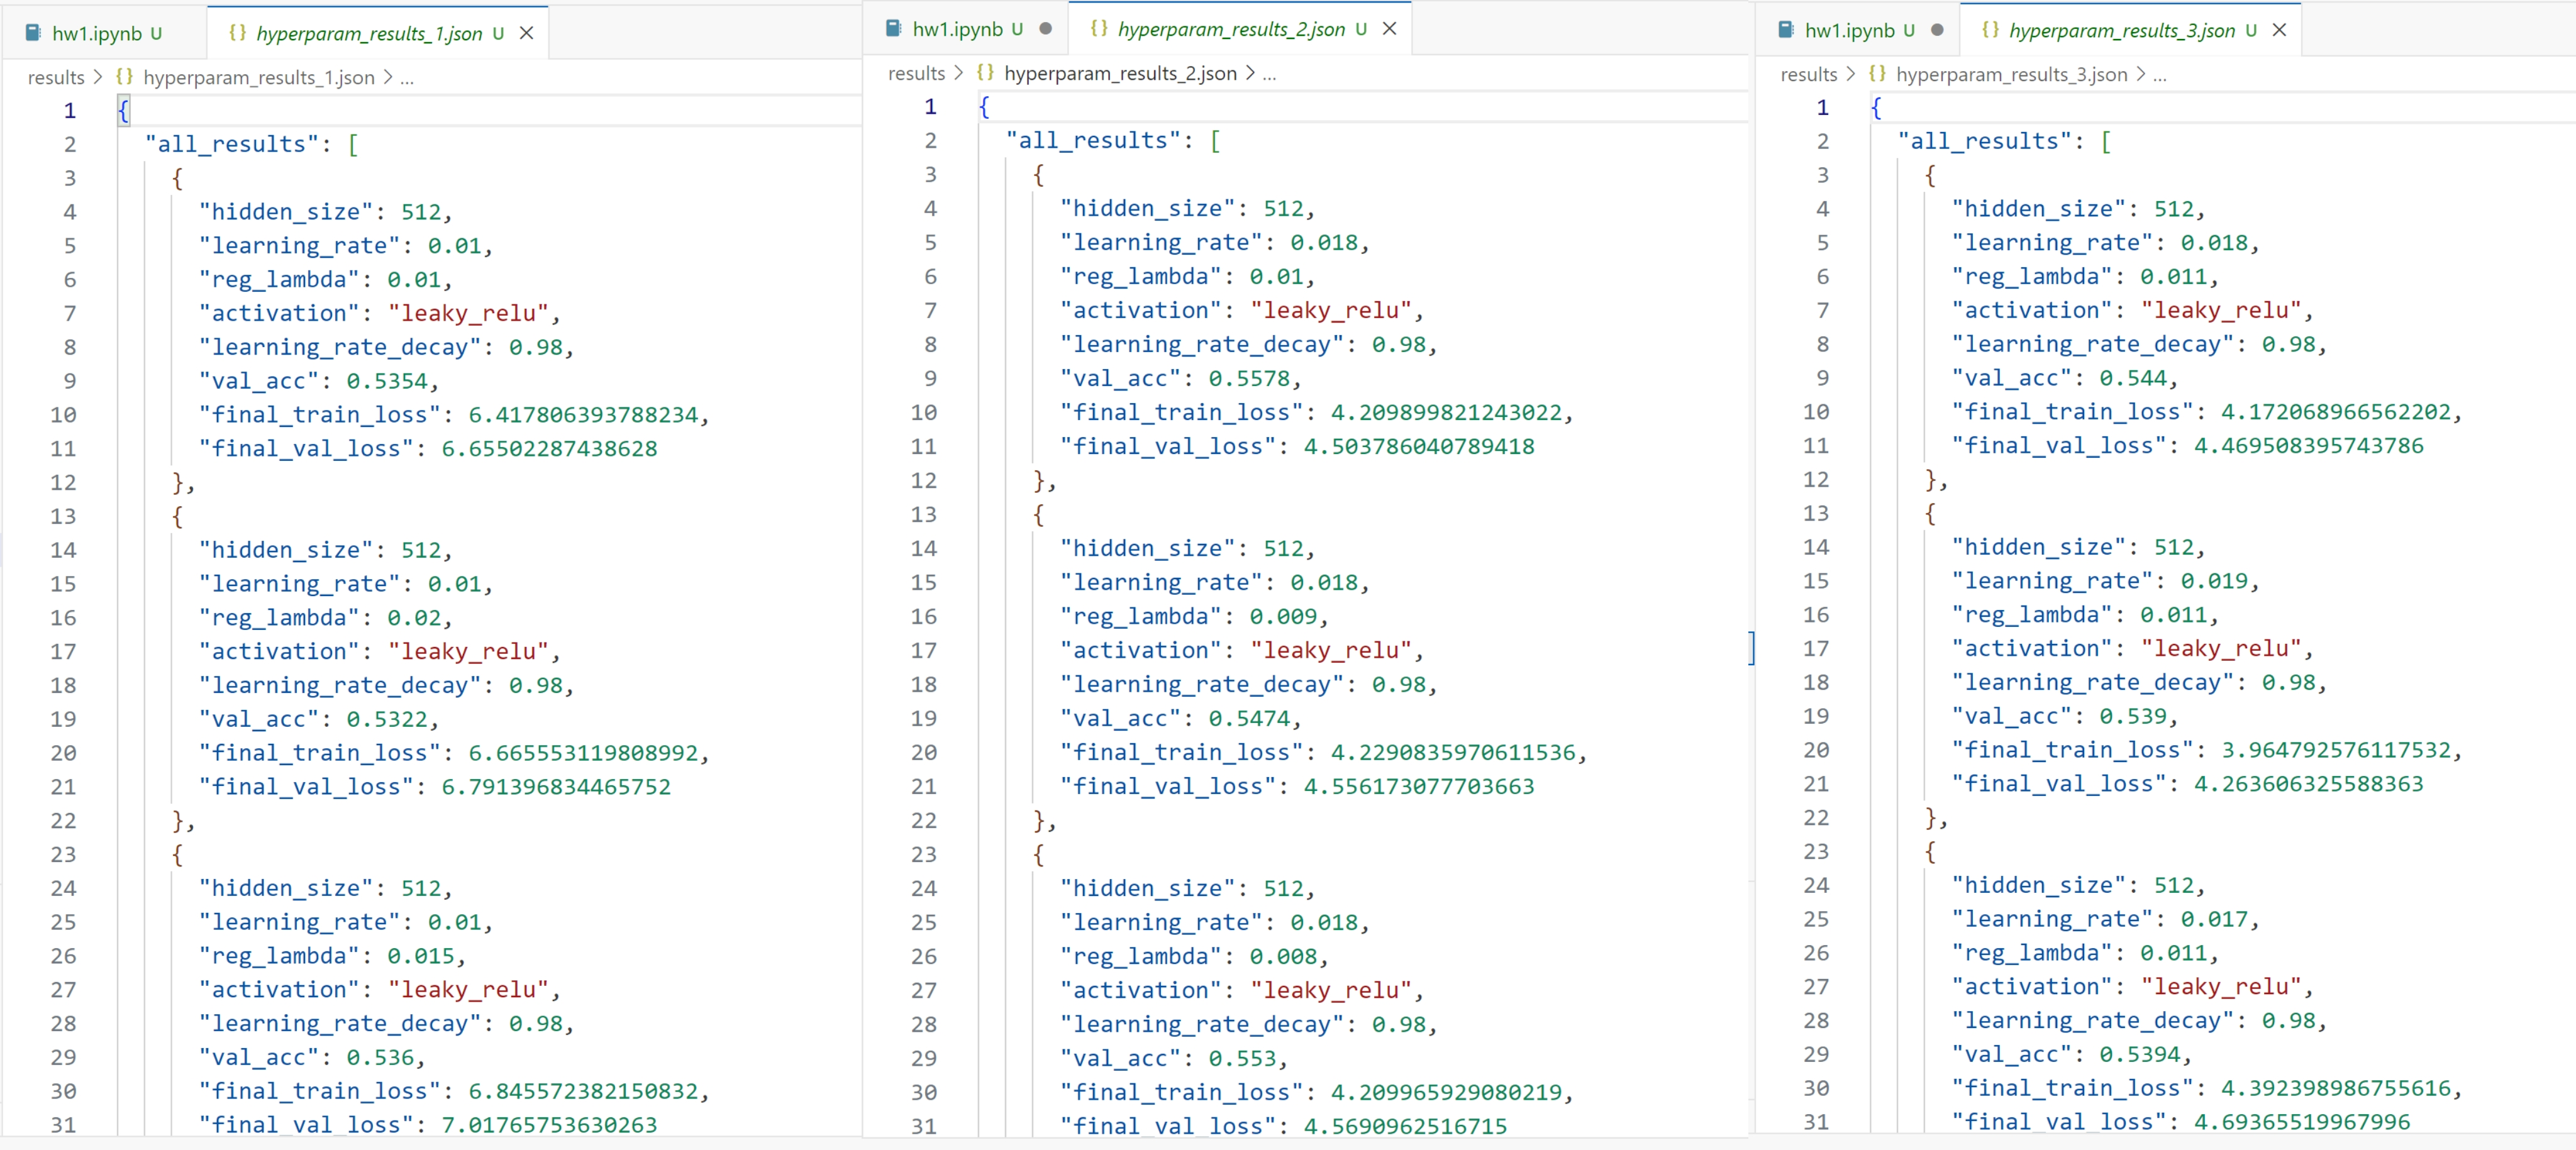

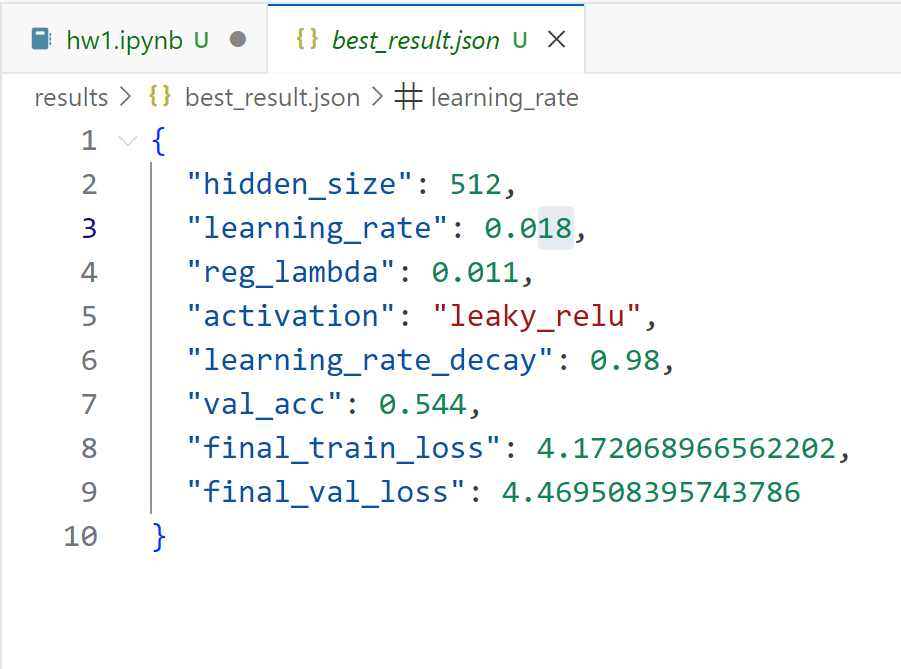

### (2) 训练曲线

从训练曲线可以看出，随着训练轮数的增加，模型的训练损失逐渐下降，训练准确率和验证准确率逐渐提高。同时，验证损失和验证准确率在训练过程中也保持稳定，说明模型没有出现过拟合现象。

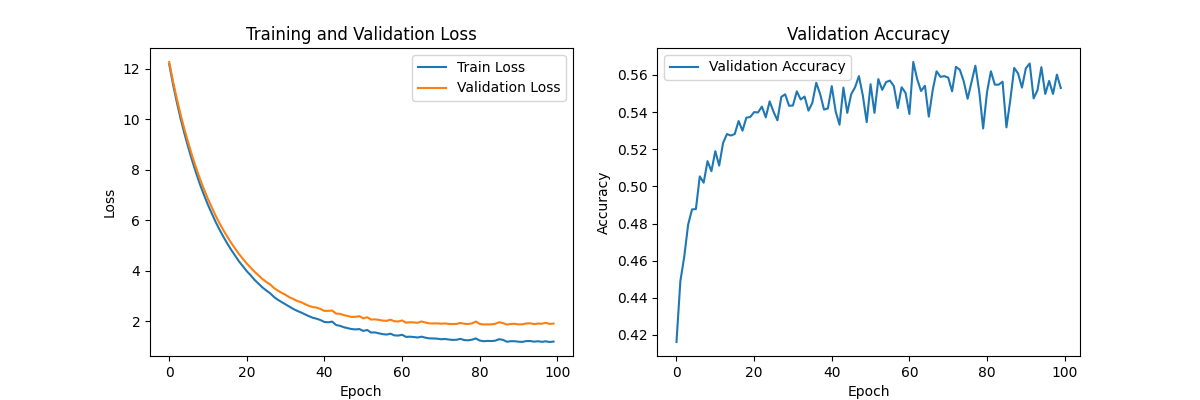

#### (3) 权重可视化

通过可视化模型第一层的权重，可以观察到模型学习到了一些与图像特征相关的模式，如边缘、纹理等。

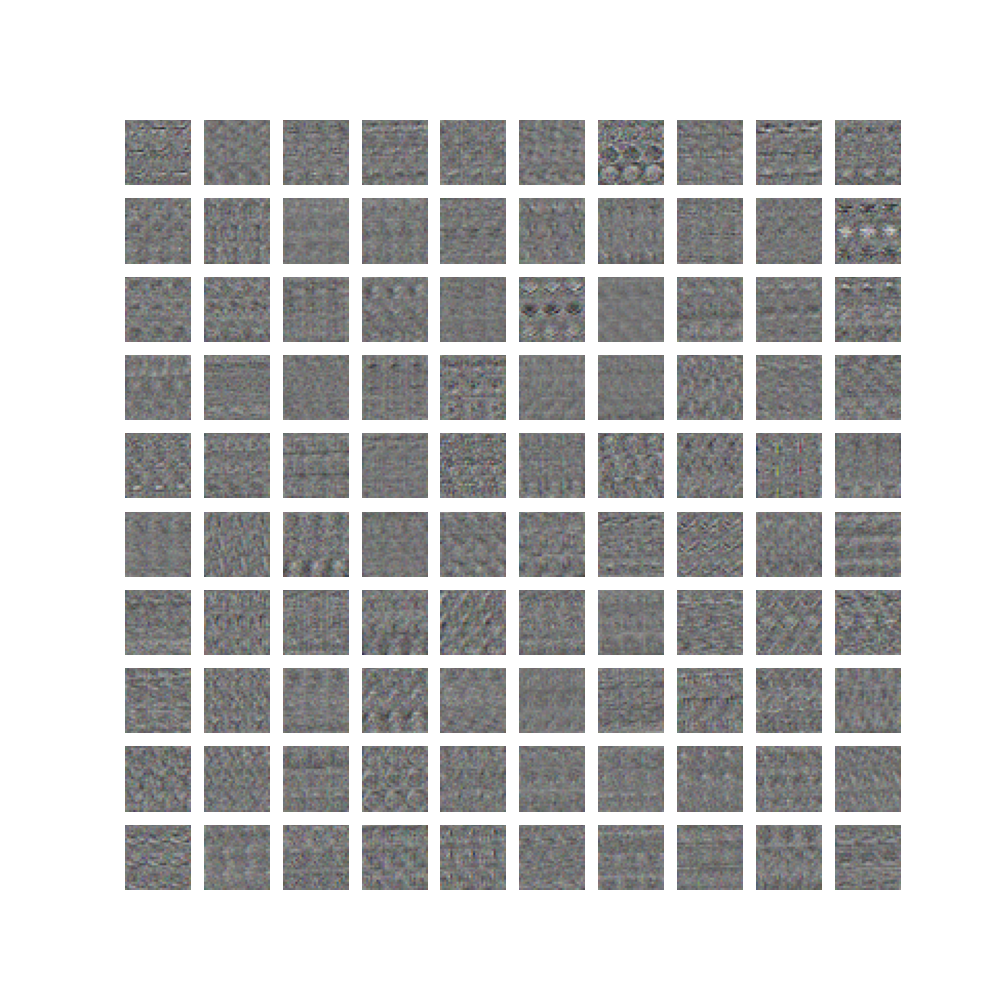

#### (4) 混淆矩阵

从混淆矩阵可以看出，模型在某些类别上的分类效果较好，而在一些类别上存在混淆的情况。例如，cat 和 dog 之间容易出现误分类，这可能是由于这些类别的图像特征较为相似。

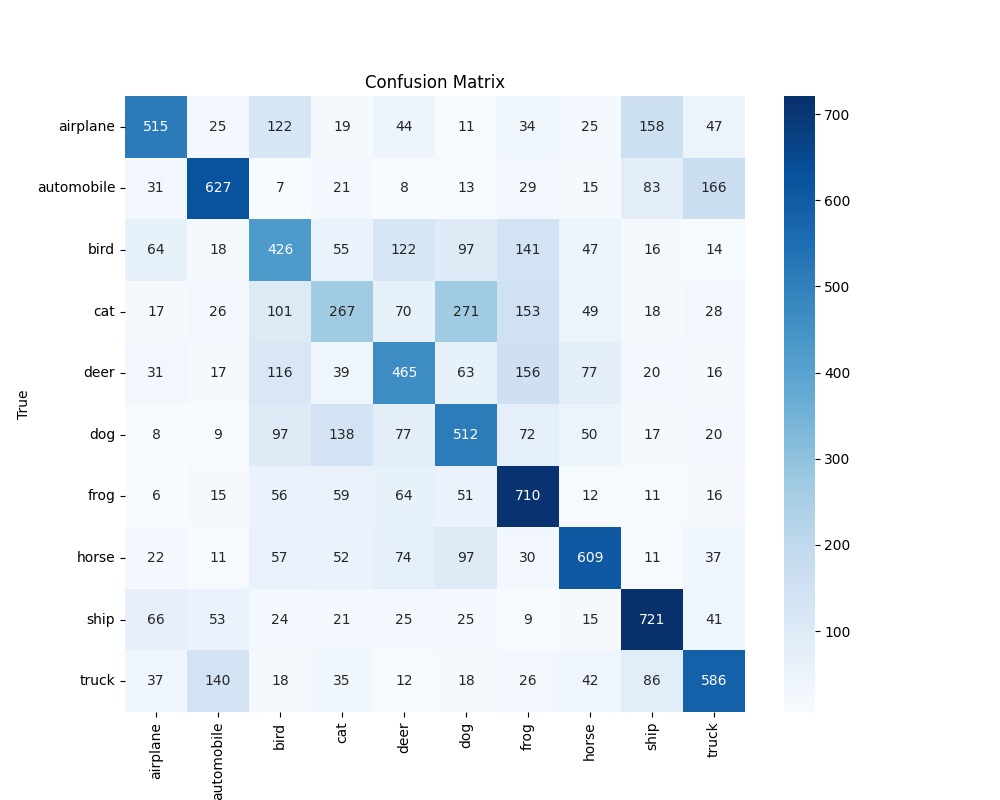

#### (5)模型记录

模型记录在我的网盘：https://pan.baidu.com/s/1zzPYsj2yEefE7U7qxRra6Q?pwd=nyv3 提取码: nyv3